In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 17 20:11:04 2022

Temporal Fusion Transformer: A Primer on Deep Forecasting in Python
https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594
https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html
"""

'\nCreated on Sun Jul 17 20:11:04 2022\n\nTemporal Fusion Transformer: A Primer on Deep Forecasting in Python\nhttps://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594\nhttps://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html\n'

seasonal? True
There is seasonality of order 12 months


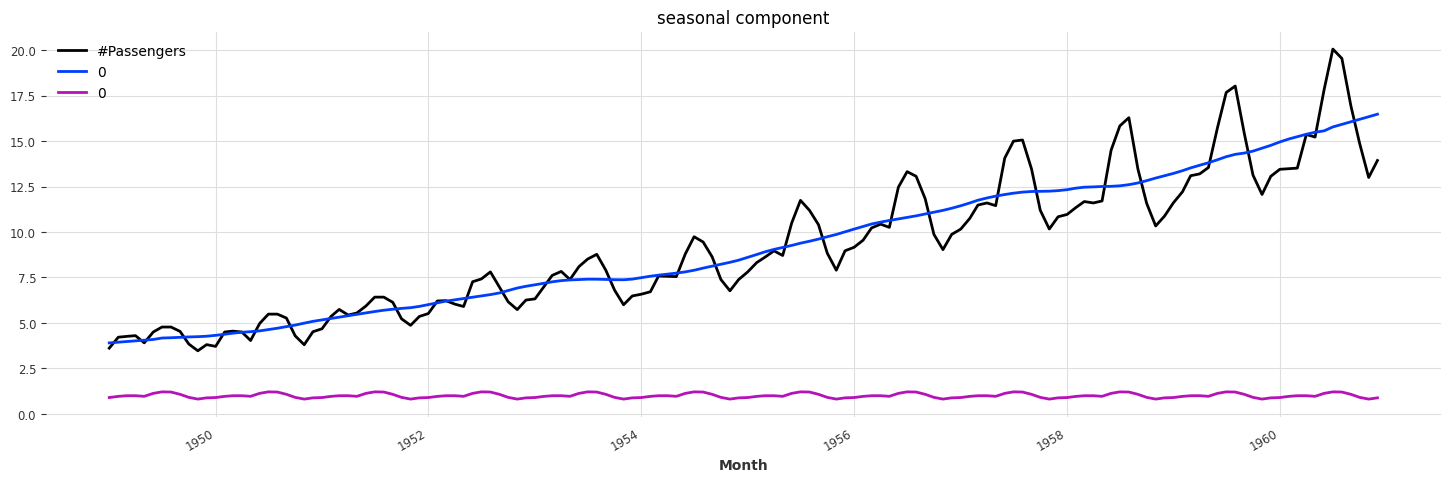

In [1]:
#===========================================#
#===== Temporal Fusion Transformer 예제 ====#
#===========================================#

##=== Settings and Dependencies ====#

#---- 기본 세팅 ----#
EPOCHS = 500        # number of training cycles
INLEN = 32          # input_chunk_length 또는 size (node count) of the input layer
HIDDEN = 64         # size of the hidden layer
LSTMLAYERS = 2      # number of layers for the LSTM encoder/decoder
ATTHEADS = 1        # number of attention heads, 장기적 패턴을 보일 것으로 예상되는 대형 모델의 경우 최대 4개의 헤드를 선택할 수 있다.
DROPOUT = 0.1       # DROPOUT rate
BATCH = 32          # BATCH size

N_FC = 36           # default number of forecast periods
RAND = 42           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # how many parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

TRAIN = "19571201"  # split the time series between training & test dataset at this time point
MSEAS = 60          # upper limit for the seasonality test: months
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)    # default size for plots

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'


#---- 필요한 라이브러리 불러오기 ----#
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format


##=== Data Wrangling and Exploration ====# 

#ts = pd.read_csv('airline-passengers.csv', delimiter=",")
ts = AirPassengersDataset().load()

# rescale: convert monthly number of passengers to average daily number of passengers per month. 
# 즉, 월 당 일수를 고려하여 월 승객수를 일 수로 나누어 일 평균 승객수로 변환  
ts = ts / TimeSeries.from_series(ts.time_index.days_in_month)
ts = ts.astype(np.float32)

# display time series in a dataframe
df = ts.pd_dataframe()
df

# 결측값 확인
df.isnull().values.any()
# False

# 데이터프레임으로부터 시계열(type이 series)을 민든다. 
ts = TimeSeries.from_series(df["#Passengers"]) 

# 시계열 산점도 만들기
plt.figure(100, figsize=(18, 5))
ts.plot();

# check for seasonality, via ACF
mseas=MSEAS
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
# seasonal? True
if is_seasonal:
    print('There is seasonality of order {} months'.format(mseas))
# There is seasonality of order 12 months    
    
# ETS(error trend seasonality) analysis: 추세(trend) 성분과 계절성(seasonality) 성분을 분해한다
ts_trend, ts_seas = extract_trend_and_seasonality(ts=ts, freq=mseas)

plt.figure(100, figsize=(18, 5))
ts_trend.plot()
plt.title("trend component");

plt.figure(100, figsize=(18, 5))
ts_seas.plot()
plt.title("seasonal component");

# train/test split for time series 
if isinstance(TRAIN, str):           # Check if TRAIN is an string. TRAIN = "19571201" 
    split = pd.Timestamp(TRAIN)      # Timestamp 객체를 생성 => Timestamp('1957-12-01 00:00:00')
else:
    split = TRAIN
    
ts_train, ts_test = ts.split_after(split)

# scale the time series on the training set transformer = Scaler()
transformer = Scaler()   # default: MinMaxScaler
ts_ttrain = transformer.fit_transform(ts_train)   # 훈련 데이터에는 fit_transform을 적용
ts_ttest = transformer.transform(ts_test)         # 검정 데이터에는 transform을 적용. transform은 훈련 데이터의 평균과 분산을 사용하여 검정 데이터를 변환
ts_t = transformer.transform(ts)                  # ts는 전체 데이터  

# covariate 만들기: year, month, and integer index series
cov = datetime_attribute_timeseries(ts, attribute="year", one_hot=False)
cov = cov.stack(datetime_attribute_timeseries(ts, attribute="month", one_hot=False))
cov = cov.stack(TimeSeries.from_times_and_values(
                                    times=ts.time_index, 
                                    values=np.arange(len(ts)), 
                                    columns=["linear_increase"]))
cov = cov.astype(np.float32)

# train/test split for covariates
train_cov, test_cov = cov.split_after(split)

# rescale the covariates: fit on the training set
scaler = Scaler()
scaler.fit(train_cov)
tcov = scaler.transform(cov)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Do the predictions constitute a probabilistic time series? True


'\n            Actual   Q50   Q99   Q95   Q90   Q10   Q05   Q01\nMonth                                                       \n1958-01-01   10.97 10.83 10.93 10.89 10.87 10.42 10.17 10.08\n1958-02-01   11.36 11.24 11.39 11.34 11.28 10.86 10.83 10.60\n1960-11-01   13.00 13.26 13.67 13.62 13.51 12.83 12.56 12.45\n1960-12-01   13.94 13.76 14.01 13.92 13.88 13.25 13.09 12.81\n'

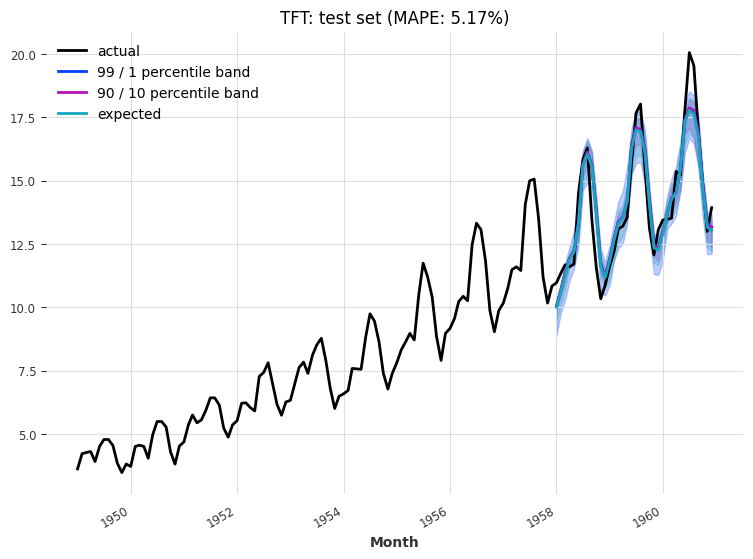

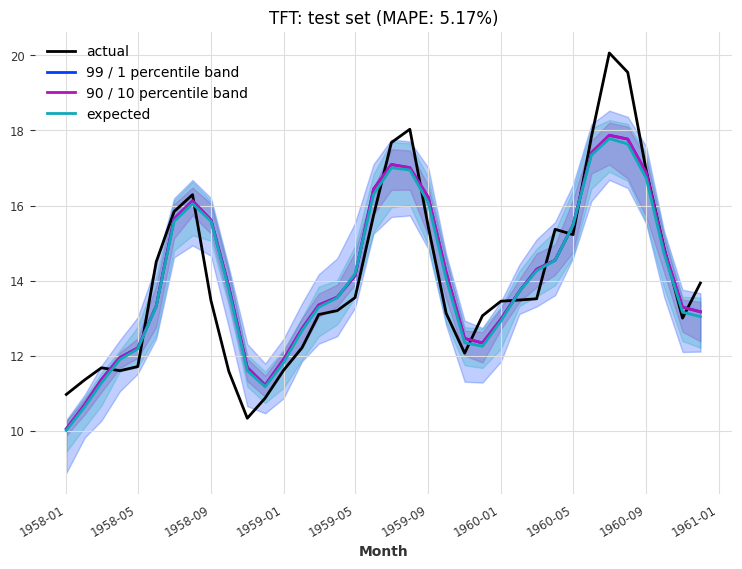

In [2]:
##=== Temporal Fusion Transformer ====# 

#---- (1) TFT Setup and Training ----#
model = TFTModel(   input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTHEADS,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    # loss_fn=MSELoss(),
                    random_state=RAND, 
                    force_reset=True)

model.fit(  ts_ttrain, 
            future_covariates=tcov, 
            verbose=True)         
            
#---- (2) TFT Testing ----#
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_test), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS)
                            
print("Do the predictions constitute a probabilistic time series?", ts_tpred.is_probabilistic)      
# Do the predictions constitute a probabilistic time series? True

# testing: helper function: plot predictions
def plot_predict(ts_actual, ts_test, ts_pred):
    
    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)
    
    ts_actual.plot(label="actual")                                       # plot actual
    
    ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
    plt.title("TFT: test set (MAPE: {:.2f}%)".format(mape(ts_test, ts_pred)))
    plt.legend();  
    
# testing: call helper function: plot predictions
ts_pred = transformer.inverse_transform(ts_tpred)
plot_predict(ts, ts_test, ts_pred)

# testing: call helper function: plot predictions, focus on test set
ts_pred = transformer.inverse_transform(ts_tpred)             # 원래 데이터 형태로 역변환
ts_actual = ts[ ts_tpred.start_time(): ts_tpred.end_time() ]  # actual values in forecast horizon
plot_predict(ts_actual, ts_test, ts_pred)

# testing: collect the prediction percentiles in a dataframe dfY
dfY = pd.DataFrame()

# helper method: calculate percentiles of predictions
def predQ(ts_tpred, q):
    ts_t = ts_tpred.quantile_timeseries(q)         # percentile of predictions
    ts = transformer.inverse_transform(ts_t)       # inverse-transform the percentile
    s = TimeSeries.pd_series(ts)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s

# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)
"""
Month
1958-01-01   10.97
1958-02-01   11.36
1958-03-01   11.68
...
1960-10-01   14.87
1960-11-01   13.00
1960-12-01   13.94
Freq: MS, Name: Actual, dtype: float32
"""

dfY
"""
            Actual   Q50   Q99   Q95   Q90   Q10   Q05   Q01
Month                                                       
1958-01-01   10.97 10.83 10.93 10.89 10.87 10.42 10.17 10.08
1958-02-01   11.36 11.24 11.39 11.34 11.28 10.86 10.83 10.60
1958-03-01   11.68 11.77 11.97 11.87 11.83 11.41 11.40 11.36
1958-04-01   11.60 12.36 12.61 12.61 12.58 11.98 11.79 11.71
...
1960-08-01   19.55 18.25 18.54 18.51 18.50 17.47 17.20 17.09
1960-09-01   16.93 17.37 17.82 17.76 17.70 16.64 16.38 16.22
1960-10-01   14.87 15.07 15.56 15.51 15.22 14.56 14.28 14.12
1960-11-01   13.00 13.26 13.67 13.62 13.51 12.83 12.56 12.45
1960-12-01   13.94 13.76 14.01 13.92 13.88 13.25 13.09 12.81
"""

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]
dfY.iloc[np.r_[0:2, -2:0]]   # np.r_[0:2, -2:0] => array([ 0,  1, -2, -1])
"""
            Actual   Q50   Q99   Q95   Q90   Q10   Q05   Q01
Month                                                       
1958-01-01   10.97 10.83 10.93 10.89 10.87 10.42 10.17 10.08
1958-02-01   11.36 11.24 11.39 11.34 11.28 10.86 10.83 10.60
1960-11-01   13.00 13.26 13.67 13.62 13.51 12.83 12.56 12.45
1960-12-01   13.94 13.76 14.01 13.92 13.88 13.25 13.09 12.81
"""

start: 1951-09-01 00:00:00
months: 111


  0%|          | 0/1 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

start: 1949-01-01 00:00:00 ; end: 1963-12-01 00:00:00


Predicting: 0it [00:00, ?it/s]

start: 1958-01-01 00:00:00 ; end: 1963-12-01 00:00:00
saved model: C:\Users\sangwoo\Lecture\202304_CVDL\git_code\Day5\_TFTmodel.pth.tar


AttributeError: 'TFTModel' object has no attribute 'save_model'

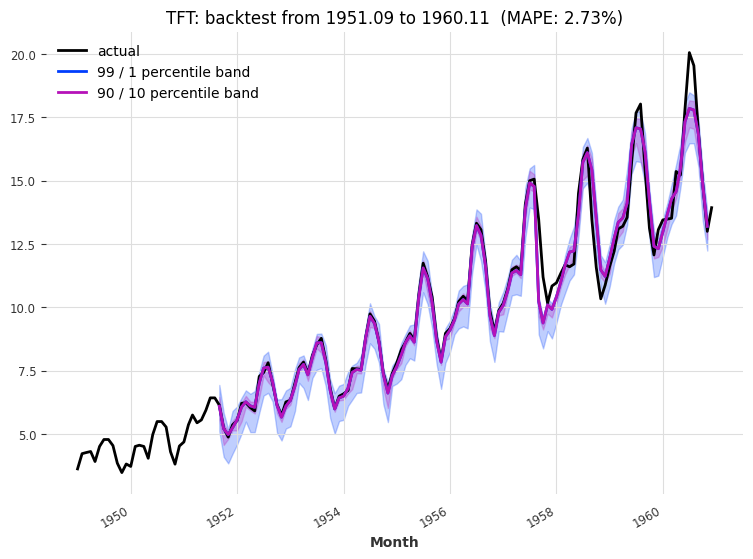

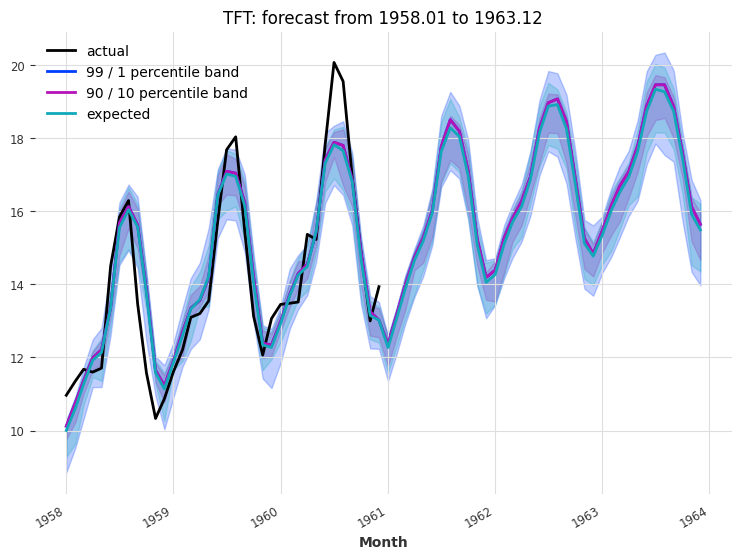

In [3]:
##----- 바로 아래부터 끝까지 당분간 공부하지 말것 -----## 
# backtest the model: predictions vs actual values

# start: at 10% of time series
STARTBACKT = ts.get_timestamp_at_point(point=max(0.2, INLEN))  #pd.Timestamp("19500301")
print("start:",STARTBACKT)

# forecast horizon: until end of test period
tdiff = (   pd.to_datetime(ts.end_time()).to_period("M") - 
            pd.to_datetime(STARTBACKT).to_period("M")).n
print("months:",tdiff)

ts_tbacktest = model.historical_forecasts(  series=ts_t,
                                            past_covariates=None, 
                                            future_covariates=tcov,
                                            start=STARTBACKT,  
                                            num_samples=N_SAMPLES,
                                            forecast_horizon=tdiff,
                                            stride=12,
                                            last_points_only=False,
                                            retrain=False,
                                            verbose=True)
                                            
                                            
# backtesting: helper function: plot backtest predictions
def plot_backtest(ts_backtest, ts_actual, transformer):
    plt.figure(figsize=FIGSIZE)
    ts_actual.plot(label="actual")
    ts_backtest.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)
    ts_backtest.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)
    plt.legend()
    MAPE = "MAPE: {:.2f}%".format(mape(ts_actual, ts_backtest))
    plt.title(  "TFT: backtest from " + \
                format(ts_backtest.start_time(), "%Y.%m") + \
                " to " + format(ts_backtest.end_time(), "%Y.%m") + \
                "  (" + MAPE + ")");
       
       
# backtesting: call helper function: plot backtest
ts_backtest = transformer.inverse_transform(ts_tbacktest)

plot_backtest(  ts_backtest=concatenate(ts_backtest),
                ts_actual=ts,
                transformer=transformer)         


#---- (3) TFT Out-of-Sample Forecast ----#
# create future covariates: year, month, integer index
FC_HORIZ = 72                       # months after end of training set
start = ts.start_time()
n_per = len(ts_train) + FC_HORIZ    # set a maximum horizon to create covariates for

# create covariates from beginning of training data to end of forecast horizon
ts_year = datetime_attribute_timeseries(
                pd.date_range(start=start, periods=n_per, freq="MS"),  #, closed="right"),
                attribute="year", 
                one_hot=False)
ts_month = datetime_attribute_timeseries(
                pd.date_range(start=start, periods=n_per, freq="MS"),  
                attribute="month", 
                one_hot=False)
cov = ts_year.stack(ts_month)
# combine year and month with integer index as third covariate
cov = cov.stack(TimeSeries.from_times_and_values(
                times=cov.time_index, 
                values=np.arange(n_per), 
                columns=['linear_increase']))

cov = cov.astype(np.float32)
tcov = scaler.transform(cov)
print("start:", cov.start_time(), "; end:",cov.end_time())



# generate future, out-of-sample predictions
ts_tpred = model.predict(n=FC_HORIZ, future_covariates=tcov, num_samples=N_SAMPLES)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())
ts_pred = transformer.inverse_transform(ts_tpred)

plt.figure(figsize=FIGSIZE)
    
ts_actual = ts.slice_intersect(other=ts_pred)
ts_actual.plot(label="actual")     

ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
plt.title(  "TFT: forecast" + \
            " from " + format(ts_tpred.start_time(), "%Y.%m") + \
            " to " + format(ts_tpred.end_time(), "%Y.%m"));  
plt.legend(); 

# forecast: collect the prediction percentiles in a dataframe
dfY = pd.DataFrame()
# call helper function predQ: percentiles of predictions
_ = [predQ(ts_tpred, q) for q in quantiles]

dfY["Actual"] = TimeSeries.pd_series(ts_actual)

dfY.iloc[np.r_[0:2, -2:0]]
"""
             Q50   Q99   Q95   Q90   Q10   Q05   Q01  Actual
Month                                                       
1958-01-01 10.84 10.95 10.87 10.87 10.46 10.41 10.16   10.97
1958-02-01 11.22 11.40 11.38 11.28 10.86 10.75 10.63   11.36
1963-11-01 16.61 17.51 17.03 16.81 15.64 15.36 15.04     NaN
1963-12-01 16.34 16.87 16.65 16.56 15.68 15.03 14.31     NaN
"""

#---- (4) TFT: Save and Reload a Model ----#
import os
mpath = os.path.abspath(os.getcwd()) + "\_TFTmodel.pth.tar"
print("saved model:", mpath)
model.save_model(mpath)

# load a saved model and generate n=60 predictions
mTFT = model.load_model(mpath)
ts_tpred = mTFT.predict(n=60, future_covariates=tcov, num_samples=N_SAMPLES)

plt.figure(figsize=FIGSIZE)
         
ts_tpred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
ts_tpred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
ts_tpred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
plt.legend(); 

#---- (5) TFT Tuning by Randomized Grid Search ----#
# randomized gridsearch
parameters = {  "input_chunk_length":[16, 32], 
                "output_chunk_length":[16,32], # 이 옵션이 없으면 에러가 발생함
                "hidden_size":[32, 64], 
                "lstm_layers":[2], 
                "num_attention_heads":[2, 3, 4], 
                "dropout":[0.1], 
                "batch_size":[32, 64], 
                "n_epochs":[1000]
                }

res = TFTModel.gridsearch(    
                            parameters=parameters,
                            series=ts_ttrain, 
                            future_covariates=tcov, 
                            val_series=ts_ttest,   
                            start=0.1,                 # starting point in training set 
                            last_points_only=False, 
                            metric=mape, 
                            reduction=np.mean, 
                            n_jobs=N_JOBS, 
                            n_random_samples=0.99,      # % of full search space to evaluate
                            verbose=True)

bestmodel, dict_bestparams = res

# training
bestmodel.fit(  ts_ttrain, 
                future_covariates=tcov, 
                verbose=True)
                
n_FC = len(ts_test)
ts_tpred =  bestmodel.predict(n_FC)
ts_pred = transformer.inverse_transform(ts_tpred)
MAPE = "MAPE after randomized gridsearch: {:.2f}%".format(mape(ts_actual, ts_pred))
print(MAPE)

In [4]:
#====================================================#
#===== ExponentialSmoothing & N-BEATS Model 예제 ====#
#====================================================#

#---- (1) ExponentialSmoothing ----# 
import pandas as pd
from darts import TimeSeries

# Read a pandas DataFrame
df = pd.read_csv('airline-passengers.csv', delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'Month', 'Passengers')

# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]

from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)


import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()


#---- (2) N-BEATS Model ----#

# loading library
import matplotlib.pyplot as plt
%matplotlib inline

#plot chart
series.plot(label="Number Of Passengers")
plt.legend();

# import
from darts.dataprocessing.transformers import Scaler

# creating scaler object
scaler_air = Scaler()

# perfoming the scaling
series_scaled = scaler_air.fit_transform(series)

# plottingair_ds.plot(label="Number Of Passengers")
series_scaled.plot(label = "Air Passangers Scaled")
plt.legend();

series_train,  series_val = series_scaled[:-36], series_scaled[-36:] 

type(series_train)
#  darts.timeseries.TimeSeries

# importing model
from darts.models import NBEATSModel    
print('model_loaded')

# creating a model object
model = NBEATSModel(input_chunk_length=24 , output_chunk_length=12, n_epochs = 100 , random_state = 15)

# fitting the model
model.fit(series_train, verbose = True)

# imports
from darts.metrics import mape
pred_air = model.predict(n = 36, series = series_train)
print("Mape = {:.2f}%".format(mape(series_scaled , pred_air)))
# Mape = 10.86%

# plotting results
series_scaled.plot(label = "actual")
pred_air.plot(label = "forecasted") # validation data set
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'airline-passengers.csv'